In [25]:
from train import *
from test import *
from layers import *
from utils import *
from loss import *
from metric import *
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [26]:
data_microbioma_train, data_microbioma_test, data_domain_train, data_domain_test, \
otu_columns, domain_columns = read_data()

# Autoencoder Bioma Bioma

In [27]:
def model(shape, input_transform, output_transform, layers_list, latent_space, activation_fn):
    return autoencoder(domain_shape=None, 
                       bioma_layers=layers_list, 
                       latent_space=latent_space,
                       input_transform=input_transform,
                       output_transform=output_transform,
                       activation_function_encoder=activation_fn,
                       activation_function_decoder=activation_fn,
                       activation_function_latent=activation_fn)

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [28]:
latent_space = 100
def model_fn():
    m, e, _, d = model(shape=717,
                      input_transform=CenterLogRatio(),
                      output_transform=None,
                      layers_list=[256,128],
                      latent_space=latent_space,
                      activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, e, None, d

In [29]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>52</b></p>

<b>loss</b>: 1.9757 (min: 1.9657, max: 1.9862)

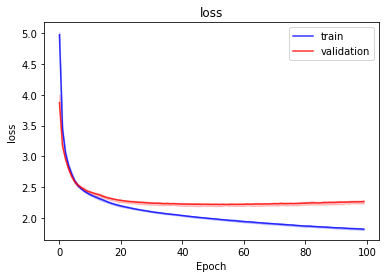

<b>bioma_BrayCurtis</b>: 0.9987 (min: 0.9987, max: 0.9987)

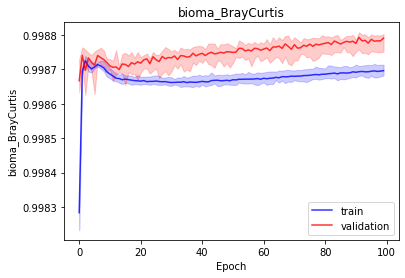

<b>bioma_pearson_corr</b>: 0.3485 (min: 0.3478, max: 0.3493)

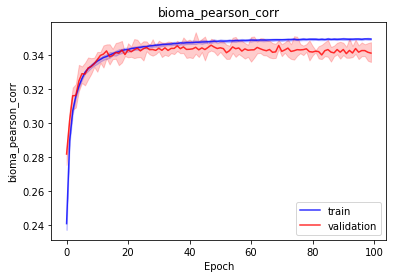

<b>bioma_jensen_shannon_divergence</b>: nan (min: nan, max: nan)

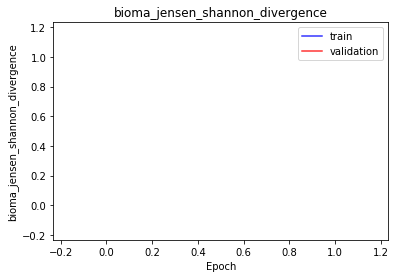

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 1.9757440392647783 | 1.965681440442564 | 1.9862340586706317 |
| bioma_BrayCurtis | 0.9986713528633118 | 0.9986616969108582 | 0.9986873865127563 |
| bioma_pearson_corr | 0.34851518273353577 | 0.3478069603443146 | 0.34933310747146606 |
| bioma_jensen_shannon_divergence | nan | nan | nan |


[('best_lost_epoch', 52),
 ('val_loss', [2.2175415328570773, 2.1894099031175887, 2.2345096383775984]),
 ('val_bioma_BrayCurtis', [0.99876136, 0.998733, 0.9987843]),
 ('val_bioma_pearson_corr', [0.34162325, 0.33797073, 0.34635264]),
 ('val_bioma_jensen_shannon_divergence', [nan, nan, nan])]

In [30]:
print_results(results)

In [31]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, model_encoder, _, _ = cv_models
        predictions = model.predict(data_microbioma_test)
        all_predictions.append(predictions)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    
    return final_predictions

In [32]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_autoencoder_bioma.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.2715207040309906 | 0.26995038986206055 | 0.27485036849975586 |
| pearson_corr | 0.8438930511474609 | 0.8405015468597412 | 0.8474021553993225 |
| jensen_shannon_divergence | 0.37838488817214966 | 0.36391523480415344 | 0.38616740703582764 |


### Best Otus
| OTU | mse |
|:----|----:|
| 238109 | 0.04882413521409035 |
| 216643 | 0.048887837678194046 |
| 242284 | 0.04889502376317978 |
| 769643 | 0.04889629781246185 |
| 883748 | 0.04898601025342941 |
| 584331 | 0.049136318266391754 |
| 11428 | 0.049194395542144775 |
| 585221 | 0.049369994550943375 |
| 833317 | 0.04939015954732895 |
| 137818 | 0.04988030716776848 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 589597 | 6.605848789215088 |
| 336745 | 6.071669101715088 |
| 594013 | 5.9357733726501465 |
| 558264 | 5.270880699157715 |
| 553648 | 5.245184421539307 |
| 338140 | 5.035150051116943 |
| 536008 | 4.844961166381836 |
| 751138 | 4.798012733459473 |
| 591499 | 4.79005241394043 |
| 17991 | 4.672762393951416 |


In [33]:
encoders = []
decoders = []
for cv_models in models:
    model, encoder, _, decoder = cv_models
    encoders.append(encoder)
    decoders.append(decoder)
    
def make_cv_predictions(data, models):
    all_predictions = []
    for m in models:
        all_predictions.append(m.predict(data))
    return np.mean(all_predictions, axis=0)

# Single regresión from domain to encoded latent space

In [37]:
target_data = make_cv_predictions(data_microbioma_train, encoders)
test_data = make_cv_predictions(data_microbioma_test, encoders)

In [43]:
def model_fn():
    in_layer = layers.Input(shape=(36,))
    out_layer = layers.Dense(100, activation=None)(in_layer)
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    model.compile(optimizer=optimizers.Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError())
    return model

In [44]:
def train_2(model_fn,
          data_encoded,
          data_domain,
          latent_space=10,
          folds=5,
          epochs=20,
          batch_size=128,
          random_seed=347,
          verbose=0):
    kf = KFold(n_splits=folds, random_state=random_seed, shuffle=True)
    results = []
    models = []
    train_callbacks = [
        callbacks.EarlyStopping(monitor='val_loss', patience=epochs + 1, restore_best_weights=True)]
    if verbose >= 0:
        train_callbacks += [TqdmCallback(verbose=verbose)]

    tf.random.set_seed(random_seed)

    for train_index, test_index in kf.split(data_domain):
        y_train, y_test = data_encoded[train_index], data_encoded[test_index]
        x_train, x_test = data_domain[train_index], data_domain[test_index]
        model = model_fn()
        metrics_prefix = 'domain'

        train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(5000).batch(
            batch_size)
        train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
        val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)
        r = model.fit(train_dataset,
                      epochs=epochs,
                      validation_data=val_dataset,
                      callbacks=train_callbacks,
                      verbose=0)
        if metrics_prefix is not None:
            old_keys = r.history
            r.history = {}
            for k, v in old_keys.items():
                if k == 'loss' or k == 'val_loss':
                    new_key = k
                elif k.startswith('val_'):
                    new_key = 'val_{}_{}'.format(metrics_prefix, k[4:])
                else:
                    new_key = '{}_{}'.format(metrics_prefix, k)
                r.history[new_key] = v
        results.append(r)
        models.append(model)
    return results, models

In [45]:
results, models = train_2(model_fn,
                        target_data,
                        data_domain_train,
                        latent_space=100,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        verbose=-1)

<p>Best iteration: <b>97</b></p>

<b>loss</b>: 0.0644 (min: 0.0641, max: 0.0648)

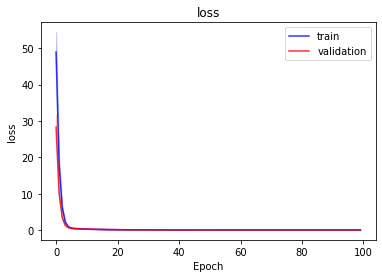

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 0.06442925594177354 | 0.06410579474725572 | 0.06475644742741304 |


[('best_lost_epoch', 97),
 ('val_loss', [0.06546933544533592, 0.06510306735123907, 0.0662798775093896])]

In [46]:
print_results(results)

In [47]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for model in models:
        predictions = model.predict(data_domain_test)
        all_predictions.append(predictions)
    final_predictions = np.mean(all_predictions,axis=0)
    
    final_decoded = make_cv_predictions(final_predictions, decoders)
    for m in metrics:
        if m.name not in metrics_results:
            metrics_results[m.name] = []
        result = m(data_microbioma_test, final_decoded)
        metrics_results[m.name] =result.numpy()
    # otus error
    se = tf.math.squared_difference(final_decoded, data_bioma_test_transformed)
    mse_otus = tf.reduce_mean(se, axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    return final_decoded

In [48]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_domain_to_encoded_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.47144973278045654 | 0.47144973278045654 | 0.47144973278045654 |
| pearson_corr | 0.640856146812439 | 0.640856146812439 | 0.640856146812439 |
| jensen_shannon_divergence | 1.0749810934066772 | 1.0749810934066772 | 1.0749810934066772 |


### Best Otus
| OTU | mse |
|:----|----:|
| 942852 | 0.7542885541915894 |
| 606989 | 0.7559062242507935 |
| 585221 | 0.7569811940193176 |
| 584331 | 0.7571796178817749 |
| 883748 | 0.7572408318519592 |
| 216643 | 0.757261335849762 |
| 833317 | 0.7589362859725952 |
| 555384 | 0.759039580821991 |
| 769643 | 0.7591172456741333 |
| 11428 | 0.7604626417160034 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 849156 | 12.951665878295898 |
| 532331 | 12.142064094543457 |
| 4318042 | 11.548846244812012 |
| 1060517 | 11.222163200378418 |
| 209233 | 10.352628707885742 |
| 691349 | 10.227660179138184 |
| 589597 | 10.113937377929688 |
| 594013 | 10.08205509185791 |
| 952203 | 10.06362247467041 |
| 185950 | 10.039155006408691 |


# Domain-Bioma 

In [49]:
def model(shape_in, shape_out, output_transform, layers_list, activation_fn):
    in_layer = layers.Input(shape=(shape_in,))
    net = in_layer
    for s in layers_list:
        net = layers.Dense(s, activation=activation_fn)(net)
    net = layers.Dense(shape_out, activation=None)(net)
    if output_transform is not None:
        net = output_transform(net)
    out_layer = net
    
    model = keras.Model(inputs=[in_layer], outputs=[out_layer], name='model')
    return model

def compile_model(model, optimizer, reconstruction_error, input_transform, output_transform):
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    model.compile(optimizer=optimizer, loss=reconstruction_error, metrics=metrics)

In [50]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128,256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, None, m, None

In [51]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>57</b></p>

<b>loss</b>: 3.7580 (min: 3.7498, max: 3.7647)

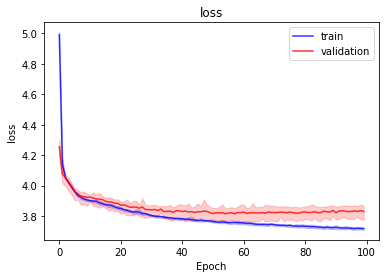

<b>domain_BrayCurtis</b>: 0.9987 (min: 0.9987, max: 0.9987)

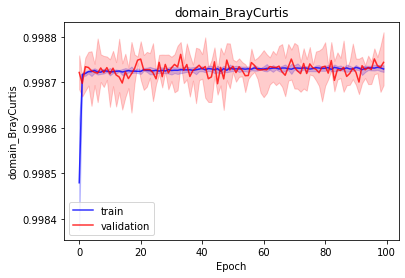

<b>domain_pearson_corr</b>: 0.3137 (min: 0.3133, max: 0.3140)

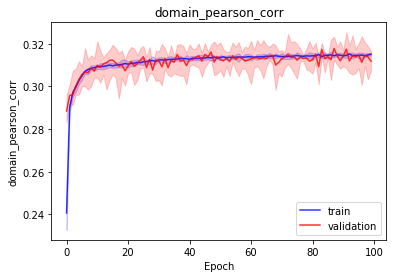

<b>domain_jensen_shannon_divergence</b>: nan (min: nan, max: nan)

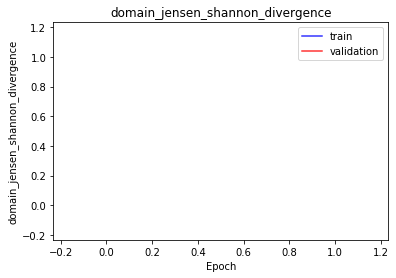

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7579967506929988 | 3.749819547139487 | 3.7647073588651767 |
| domain_BrayCurtis | 0.9987317323684692 | 0.9987255334854126 | 0.9987378716468811 |
| domain_pearson_corr | 0.3137356638908386 | 0.31329628825187683 | 0.3139525055885315 |
| domain_jensen_shannon_divergence | nan | nan | nan |


[('best_lost_epoch', 57),
 ('val_loss', [3.815086044584002, 3.76842771257673, 3.8517206055777415]),
 ('val_domain_BrayCurtis', [0.99873734, 0.9987228, 0.998749]),
 ('val_domain_pearson_corr', [0.31315356, 0.3081407, 0.31603402]),
 ('val_domain_jensen_shannon_divergence', [nan, nan, nan])]

In [52]:
print_results(results)

In [53]:
def test_model(models, input_transform, output_transform):
    data_bioma_test_transformed = data_microbioma_test
    if input_transform is not None:
        input_transform = input_transform()
        data_bioma_test_transformed = input_transform(data_microbioma_test)
    if output_transform is not None:
        output_transform = output_transform()
    metrics_results = {}
    metrics = get_experiment_metrics(input_transform, output_transform)[0][3:]
    otus_errors = []
    all_predictions = []
    for cv_models in models:
        model, _, _, _ = cv_models
        predictions = model.predict(data_domain_test)
        all_predictions.append(predictions)
        for m in metrics:
            if m.name not in metrics_results:
                metrics_results[m.name] = []
            result = m(data_microbioma_test, predictions)
            m.reset_states()
            metrics_results[m.name].append(result.numpy())
        # otus error
        se = tf.math.squared_difference(predictions, data_bioma_test_transformed)
        mse = tf.reduce_mean(se, axis=0)
        otus_errors.append(mse)
    mse_otus = tf.reduce_mean(tf.stack(otus_errors, axis=0), axis=0)
    mse_otus_keys = sorted(zip(mse_otus.numpy(), otu_columns), key=lambda x: x[0])
    for k, v in list(metrics_results.items()):
        v = np.asarray(v)
        metrics_results[k] = (v.mean(), v.min(), v.max())
    
    md_text = "## Test results \n"
    md_text += "| Metric           | Mean    | Min     | Max     |\n"
    md_text += "|:-----------------|--------:|--------:|--------:|\n"
    for k, v in metrics_results.items():
        md_text += "| {} | {} | {} | {} |\n".format(k, v[0], v[1], v[2])


    display(Markdown(md_text))

    md_text ="### Best Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in mse_otus_keys[:10]:
        md_text += "| {} | {} |\n".format(k, v)
    md_text += "\n\n"
    md_text +="### Worst Otus\n"
    md_text += "| OTU | mse |\n"
    md_text += "|:----|----:|\n"
    for v, k in reversed(mse_otus_keys[-10:]):
        md_text += "| {} | {} |\n".format(k, v)

    display(Markdown(md_text))
    
    final_predictions = np.mean(all_predictions,axis=0)
    return final_predictions

In [54]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_linear_regresion.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4159122109413147 | 0.41300323605537415 | 0.4209136664867401 |
| pearson_corr | 0.7259584665298462 | 0.7154849767684937 | 0.7305828332901001 |
| jensen_shannon_divergence | 0.8394817113876343 | 0.8233330845832825 | 0.8603849411010742 |


### Best Otus
| OTU | mse |
|:----|----:|
| 769643 | 0.6857694983482361 |
| 585221 | 0.6872621774673462 |
| 238109 | 0.6878722906112671 |
| 833317 | 0.6881008744239807 |
| 510316 | 0.6881455779075623 |
| 883748 | 0.68876713514328 |
| 137818 | 0.6891464591026306 |
| 242284 | 0.6892388463020325 |
| 810679 | 0.6895765066146851 |
| 606989 | 0.6896019577980042 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 532331 | 11.282445907592773 |
| 849156 | 10.624791145324707 |
| 594013 | 10.144647598266602 |
| 4318042 | 10.13542652130127 |
| 691349 | 10.018590927124023 |
| 1060517 | 9.841435432434082 |
| 589597 | 9.48969841003418 |
| 107234 | 9.055900573730469 |
| 816441 | 8.979803085327148 |
| 558264 | 8.91252326965332 |


# Autoencoder-like from domain

In [55]:
def model_fn():
    m = model(shape_in=36,
              shape_out=717,
              output_transform=None,
              layers_list=[128, 100, 128, 256],
              activation_fn='tanh')
    
    compile_model(model=m,
                  optimizer=optimizers.Adam(lr=0.001),
                  reconstruction_error=LossMeanSquaredErrorWrapper(CenterLogRatio(), None),
                  input_transform=CenterLogRatio,
                  output_transform=None)
    return m, None, m, None

In [56]:
results, models = train(model_fn,
                        data_microbioma_train,
                        data_domain_train,
                        latent_space=latent_space,
                        folds=5,
                        epochs=100,
                        batch_size=64,
                        learning_rate_scheduler=None,
                        verbose=-1)

<p>Best iteration: <b>44</b></p>

<b>loss</b>: 3.7689 (min: 3.7625, max: 3.7863)

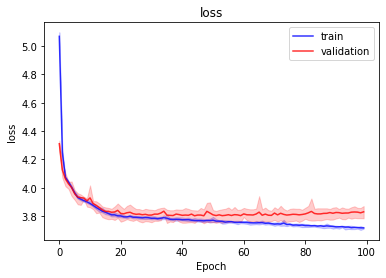

<b>domain_BrayCurtis</b>: 0.9987 (min: 0.9987, max: 0.9987)

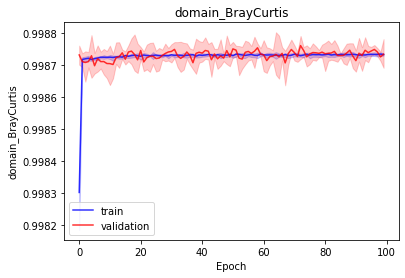

<b>domain_pearson_corr</b>: 0.3141 (min: 0.3130, max: 0.3149)

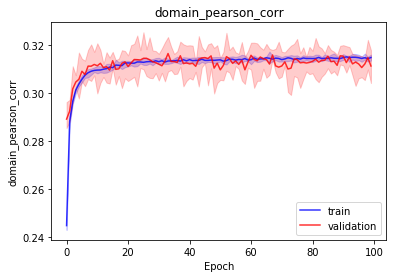

<b>domain_jensen_shannon_divergence</b>: nan (min: nan, max: nan)

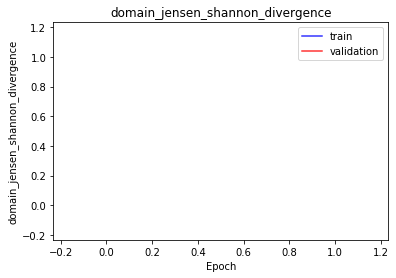

| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| loss | 3.7689280467476514 | 3.7625014019937804 | 3.786265390059527 |
| domain_BrayCurtis | 0.9987279772758484 | 0.9987227320671082 | 0.9987332224845886 |
| domain_pearson_corr | 0.3141288459300995 | 0.312971293926239 | 0.314873069524765 |
| domain_jensen_shannon_divergence | nan | nan | nan |


[('best_lost_epoch', 44),
 ('val_loss', [3.8022494384220673, 3.7518540961401805, 3.8405040502548218]),
 ('val_domain_BrayCurtis', [0.998734, 0.9987204, 0.9987494]),
 ('val_domain_pearson_corr', [0.31465805, 0.31079194, 0.31920612]),
 ('val_domain_jensen_shannon_divergence', [nan, nan, nan])]

In [57]:
print_results(results)

In [58]:
predictions = test_model(models, CenterLogRatio, None)
save_predictions(predictions, 'experiment_fake_domain_autoencoder.txt')

## Test results 
| Metric           | Mean    | Min     | Max     |
|:-----------------|--------:|--------:|--------:|
| BrayCurtis | 0.4148046374320984 | 0.4128890931606293 | 0.41636577248573303 |
| pearson_corr | 0.7307088971138 | 0.7287275195121765 | 0.7326630353927612 |
| jensen_shannon_divergence | 0.8370887041091919 | 0.8271368741989136 | 0.8466781377792358 |


### Best Otus
| OTU | mse |
|:----|----:|
| 242284 | 0.7140215635299683 |
| 584331 | 0.7147683501243591 |
| 216643 | 0.7164713144302368 |
| 238109 | 0.7171582579612732 |
| 137818 | 0.7195214033126831 |
| 769643 | 0.7210509181022644 |
| 810679 | 0.7213066816329956 |
| 11428 | 0.7218171954154968 |
| 510316 | 0.7221739888191223 |
| 585221 | 0.7223916053771973 |


### Worst Otus
| OTU | mse |
|:----|----:|
| 532331 | 11.386698722839355 |
| 849156 | 10.625410079956055 |
| 4318042 | 10.175653457641602 |
| 594013 | 10.1095609664917 |
| 691349 | 10.06861400604248 |
| 1060517 | 9.708620071411133 |
| 589597 | 9.567708969116211 |
| 107234 | 9.150023460388184 |
| 816441 | 9.053908348083496 |
| 103869 | 8.965778350830078 |
